In [1]:
import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot
import math
from coffea import util
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

In [2]:
out_dir = "../data/github_examples/cutflow"

# Table of contents <a class="anchor" id="toc"></a>

Create...

* [Cutflow tables](#table)
* [Cutflow plots for simulation](#plot-sim)
* [Cutflow plots for data](#plot-data)
* [Cutflow plots for simulation and data](#plot)
* [Cutflow plots for simulation (separate)](#plot-sim-sep)

# Create cutflow tables <a class="anchor" id="table"></a>
[Back to Table of Contents](#toc)

In [13]:
# MC only
# Table displaying number of events after each selection

df = pd.DataFrame([])

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]

h =  mc.project('cut', 'process')

processes = ["QCD", "ZJets", "W", "TTbar", "VV", "ggF", "VBF", "ttH", "ZH", "WH"]

for process in processes:

    df[process] = h[:, hist.loc(process)].values()
    
df.index = ['Baseline','Trigger','Min. kin.', 'Jet ID','MET','No leptons']

df.style.format("{:,.2f}")

,QCD,ZJets,W,TTbar,VV,ggF,VBF,ttH,ZH,WH
Baseline,"11,148,646,015.17","25,158,654.51","62,690,391.89","45,019,284.68","3,003,270.25","10,354.56","82,301.30","11,308.13","14,754.64","29,488.94"
Trigger,"11,148,646,015.17","25,158,654.51","62,690,391.89","45,019,284.68","3,003,270.25","10,354.56","82,301.30","11,308.13","14,754.64","29,488.94"
Min. kin.,"64,103,655.88","206,139.18","534,093.91","1,313,617.03","20,486.31","1,299.57",538.66,"1,282.99",275.83,432.66
Jet ID,"64,042,783.40","206,017.53","533,716.20","1,297,135.72","19,381.99","1,299.14",537.95,"1,277.93",265.02,429.73
MET,"63,024,521.83","201,781.73","524,451.89","1,028,256.70","15,140.06","1,261.82",512.16,"1,063.47",247.76,323.39
No leptons,"60,561,508.15","191,926.54","501,707.20","650,182.10","10,660.41","1,199.80",484.68,775.25,215.28,287.71


In [12]:
# MC only
# Table displaying the number of events after each selection relative to the previous selection (as %)

df1 = pd.DataFrame([])

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]

h =  mc.project('cut', 'process')

processes = ["QCD", "ZJets", "W", "TTbar", "VV", "ggF", "VBF", "ttH", "ZH", "WH"]

for column in processes:

    rel_percentage = []

    for i in range(len(df[column])):
        rel_percentage.append(df[column][i] / df[column][i-1 if i > 1 else 0] * 100)

    df1[f"{column} (rel %)"] = rel_percentage

df1.index = ['Baseline','Trigger','Min. kin.', 'Jet ID','MET','No leptons']
    
df1.style.format("{:,.2f}")

,QCD (rel %),ZJets (rel %),W (rel %),TTbar (rel %),VV (rel %),ggF (rel %),VBF (rel %),ttH (rel %),ZH (rel %),WH (rel %)
Baseline,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Trigger,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Min. kin.,0.57,0.82,0.85,2.92,0.68,12.55,0.65,11.35,1.87,1.47
Jet ID,99.91,99.94,99.93,98.75,94.61,99.97,99.87,99.61,96.08,99.32
MET,98.41,97.94,98.26,79.27,78.11,97.13,95.21,83.22,93.49,75.25
No leptons,96.09,95.12,95.66,63.23,70.41,95.09,94.63,72.90,86.89,88.96


In [18]:
# Data and MC
# Both type of tables in one

df = pd.DataFrame([])

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))["hist"]
data = pickle.load(open(f'{out_dir}/data.pkl','rb'))

for sample, process in [(data, 'Run3Summer22EE'), (mc, "MC")]:
    
    h = sample.project('cut', 'process')
    
    df[process] = h[:, sum].values()
    
    df.index = ['Baseline','Trigger','Min. kin.', 'Jet ID','MET','No leptons']

for column in ['Run3Summer22EE', "MC"]:

    percentage = []

    for i in range(len(df[column])):
        percentage.append(df[column][i] / df[column][0] * 100)

for column in ['Run3Summer22EE', "MC"]:

    rel_percentage = []

    for i in range(len(df[column])):
        rel_percentage.append(df[column][i] / df[column][i-1 if i > 1 else 0] * 100)

    df[f"{column} (rel %)"] = rel_percentage

df[2:].style.format("{:,.2f}")

,Run3Summer22EE,MC,Run3Summer22EE (rel %),MC (rel %)
Min. kin.,"71,643,759.00","66,184,352.17",1.92,0.59
Jet ID,"70,865,474.00","66,105,355.25",98.91,99.88
MET,"69,243,811.00","64,799,707.59",97.71,98.02
No leptons,"65,971,850.00","61,920,710.03",95.27,95.56


In [19]:
# MC only
# Table displaying the number of events in the signal region relative to all events (as %) for 110 < mass < 138 GeV

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]

pts = mc.project('pt').axes[0].edges
h =  mc.project('pt', 'disc', 'mass', 'genflav', 'cut', 'process')

df = pd.DataFrame([])

processes = ["QCD", "ZJetsqq", "ZJetsbb", "W", "TTbar", "VV", "ggF", "VBF", "ttH", "ZH", "WH"]

for name in processes:
    
    process = name
    genflav = sum
    
    if process == "ZJetsbb":
        process = "ZJets"
        genflav = slice(3, len, sum)
    elif process == "ZJetsqq":
        process = "ZJets"
        genflav = slice(1, 3, sum)
    
    p = h[:, 3:len:sum, hist.loc(110):hist.loc(138):sum, genflav, -1, hist.loc(process)].values()
    a = h[:, 0:len:sum, hist.loc(110):hist.loc(138):sum, genflav, -1, hist.loc(process)].values()
    
    df[name] = p / a * 100

    index = []

    for pt_i, _ in enumerate(pts[:-1]):
        index.append(f"{pts[pt_i]:.0f} < pt < {pts[pt_i+1]:.0f}")
        
    df.index = index

print("110 < m_reg < 138 GeV")
df.style.format("{:,.2f}")

110 < m_reg < 138 GeV


,QCD,ZJetsqq,ZJetsbb,W,TTbar,VV,ggF,VBF,ttH,ZH,WH
300 < pt < 350,1.55,1.99,27.02,1.01,8.13,2.61,46.44,48.74,20.27,43.61,44.77
350 < pt < 400,1.03,1.60,23.01,0.54,6.97,1.94,49.08,55.64,21.59,46.49,47.21
400 < pt < 450,1.04,1.54,20.72,0.57,6.73,2.07,52.46,60.86,23.66,49.22,49.79
450 < pt < 500,0.96,1.65,21.63,0.76,6.65,1.81,51.33,55.53,24.47,49.96,50.57
500 < pt < 550,0.88,1.40,20.97,0.77,6.50,2.00,55.15,57.41,26.06,50.58,50.08
550 < pt < 600,1.09,1.74,21.25,0.55,6.15,2.61,44.12,57.34,27.21,45.23,52.65
600 < pt < 675,0.82,1.85,18.67,1.13,5.76,2.22,57.43,49.69,29.24,45.69,50.64
675 < pt < 800,0.77,1.45,19.62,0.13,5.66,2.40,62.88,61.99,26.70,48.19,52.44
800 < pt < 1200,0.69,2.80,16.90,0.31,4.20,3.86,56.75,55.68,32.09,43.10,53.57


# Create cutflow plots for simulation <a class="anchor" id="plot-sim"></a>
[Back to Table of Contents](#toc)

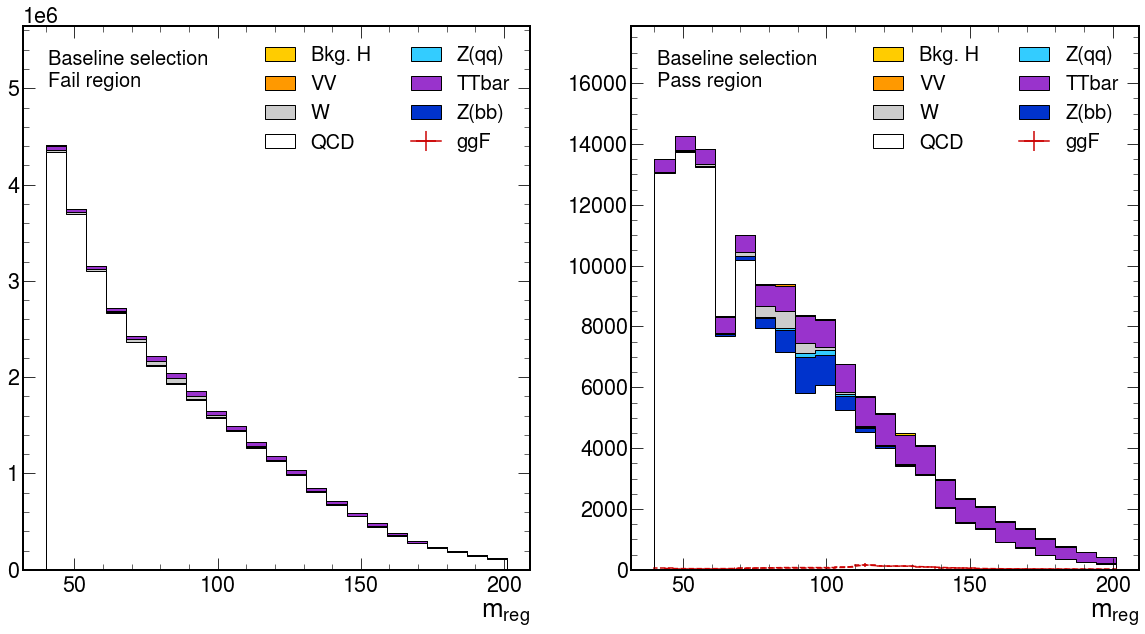

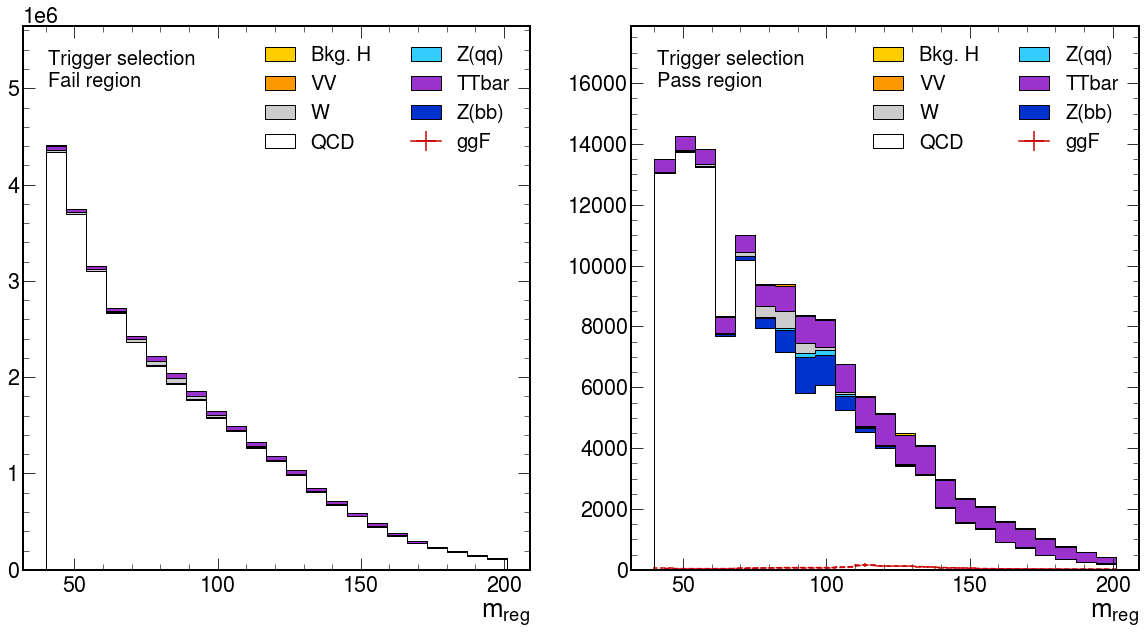

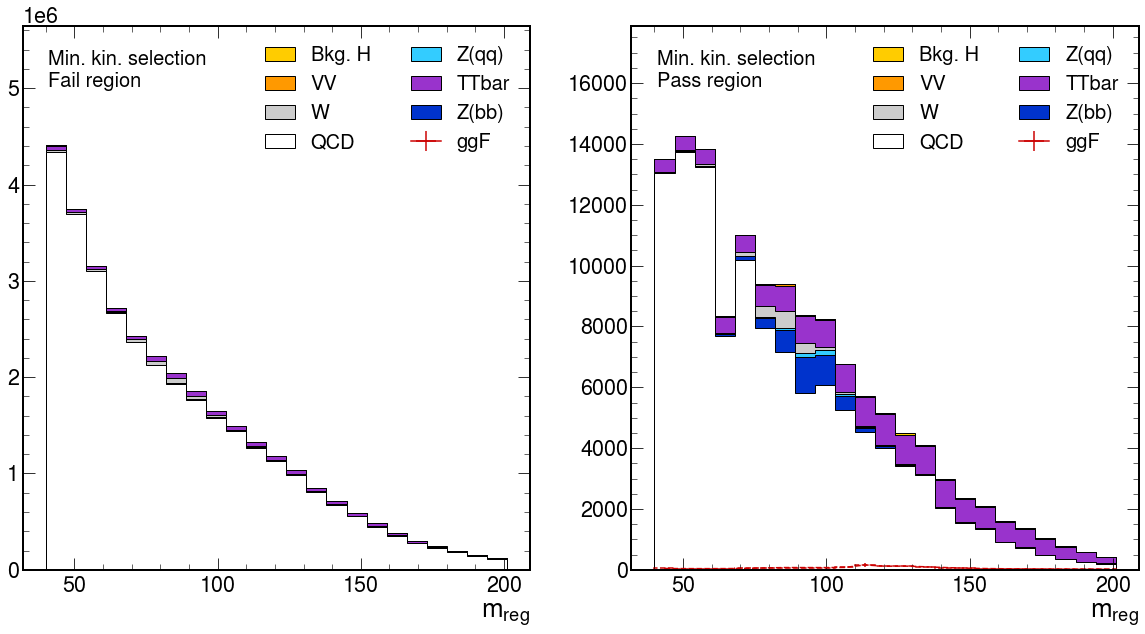

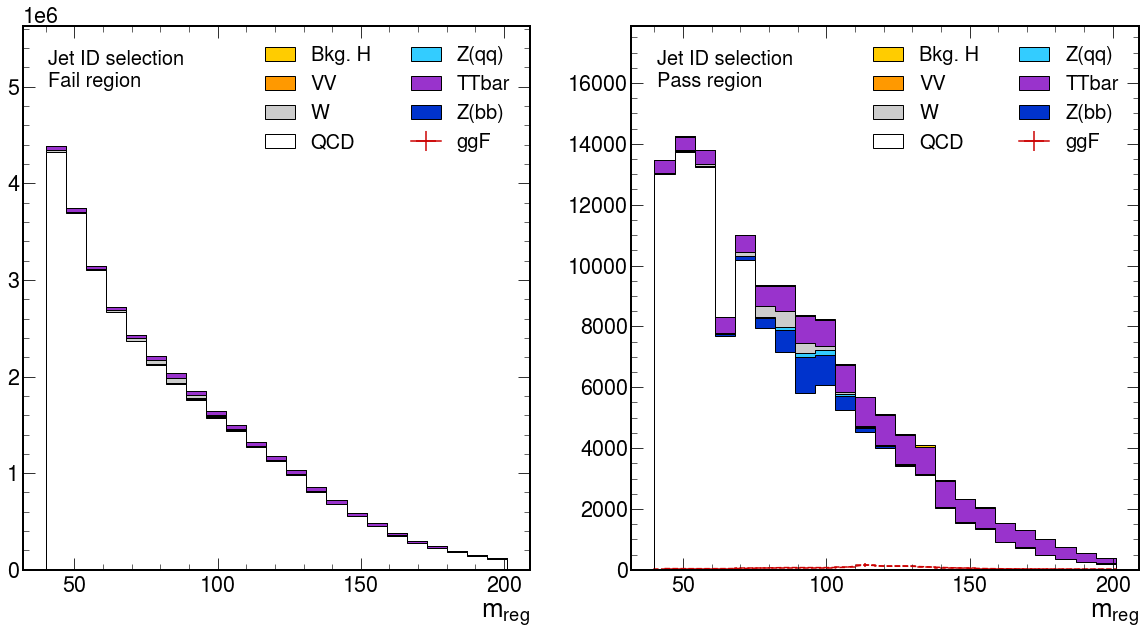

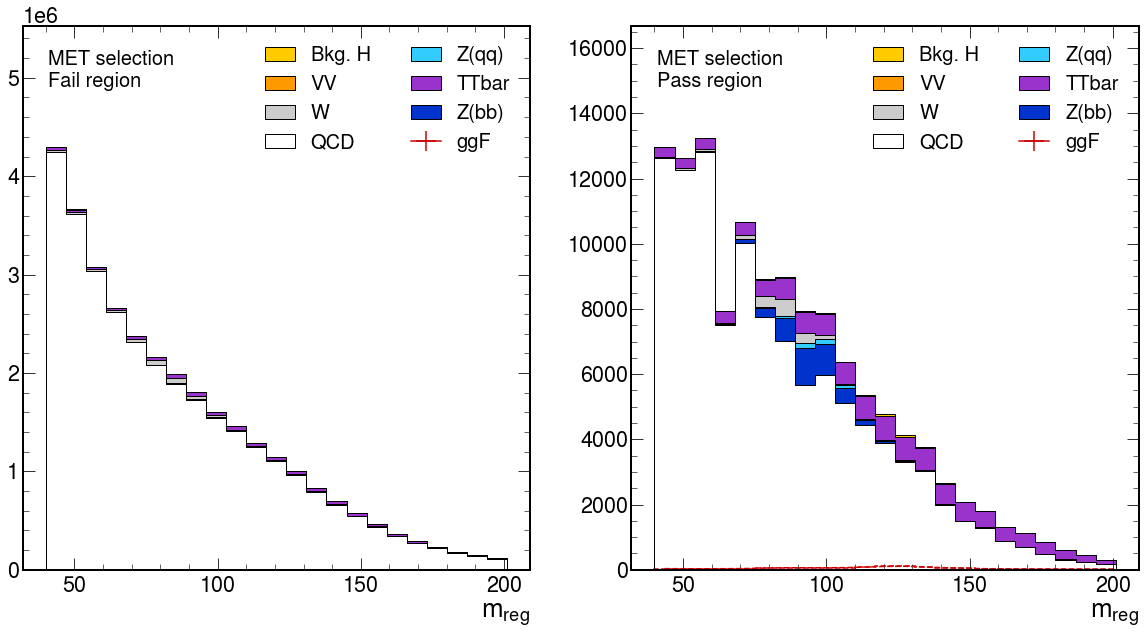

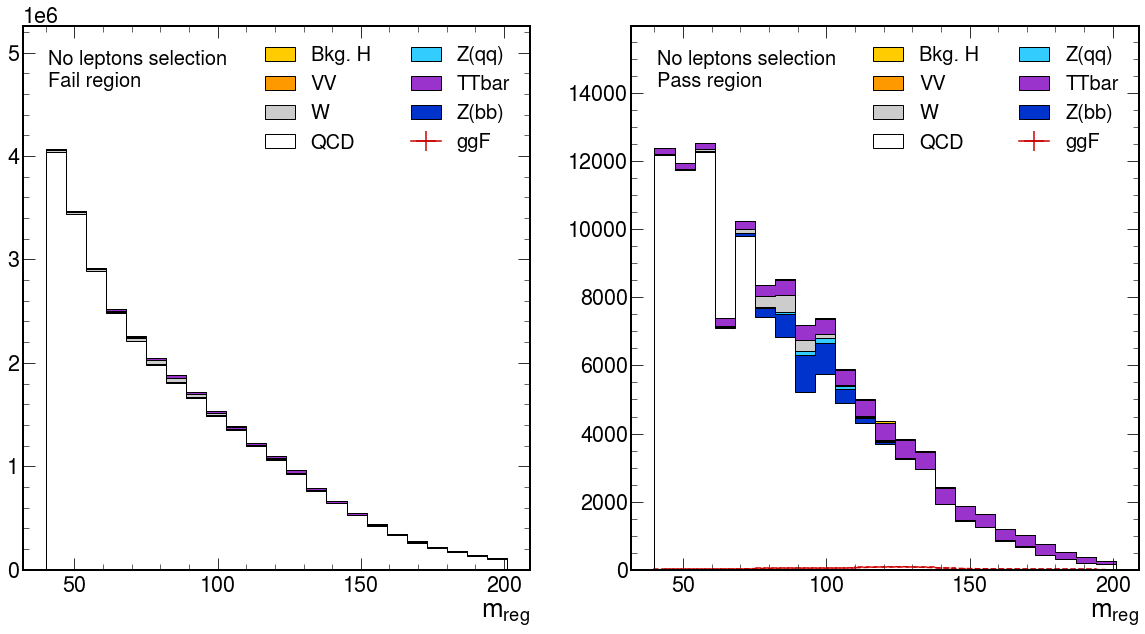

In [24]:
# MC only
# Cutflow plots

plt.style.use(mplhep.style.CMS)

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]

colour = {
    "QCD" : "white",
    "Z(bb)" : "#0033cc",
    "Z(qq)" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "Bkg. H" : "#ffcc00",
}

wp = 0.9864132

selections = ['Baseline','Trigger','Min. kin.', 'Jet ID','MET','No leptons']

def get_sel(h, region, process, cut):
    
    alias = {
        "Z(bb)" : hist.loc("ZJets"),
        "Z(qq)" : hist.loc("ZJets"),
        "All mc" : sum,
    }
    
    sel = {
        "pt" : slice(hist.loc(350), len, sum),
        "cut" : cut,
        "process" : alias[process] if process in alias.keys() else hist.loc(process),
    }
    
    h = h[sel]
    
    if process == "Z(bb)":
        h = h[{"genflav" : slice(3, 4, sum)}]
    elif process == "Z(qq)":
        h = h[{"genflav" : slice(1, 3, sum)}]
    else:
        h = h[{"genflav" : slice(0, len, sum)}]
        
    if "Pass" in region:
        h = h[{"disc" : slice(hist.loc(wp), len, sum)}]
    else:
        h = h[{"disc" : slice(0, hist.loc(wp), sum)}]
        
    if process == "data" and region == "Pass":
        for i in [12, 13, 14, 15]:
                h[i] = [np.nan, np.nan]
        
    return h

for i_sel, selection in enumerate(selections):
        
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(20, 10),
    )
    fig.subplots_adjust(wspace=0.2)

    for region, ax in [("Fail", ax1), ("Pass", ax2)]:
    
        ax.set_xlabel(r"$m_{reg}$")

        hs = []
        labels = []
        colours = []

        for process in colour.keys():

            h = get_sel(mc, region, process, i_sel)

            hs.append(h)
            labels.append(process)
            colours.append(colour[process])

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
        )

        h_ggF = get_sel(mc, "ggF", process, i_sel)

        mplhep.histplot(
            h_ggF, 
            ax=ax, 
            color="#cc0000",
            label=f"ggF",
            linestyle="dashed",
        )

        plt.text(0.05, 0.88, f"{selection} selection\n{region} region",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        handles, labels = ax.get_legend_handles_labels()
        order = [0, 1, 3, 6, 4, 2, 5, 7]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

        ax.set_ylim(0, max(hs[0].values()) * 1.3)

# Create cutflow plots for data <a class="anchor" id="plot-data"></a>
[Back to Table of Contents](#toc)

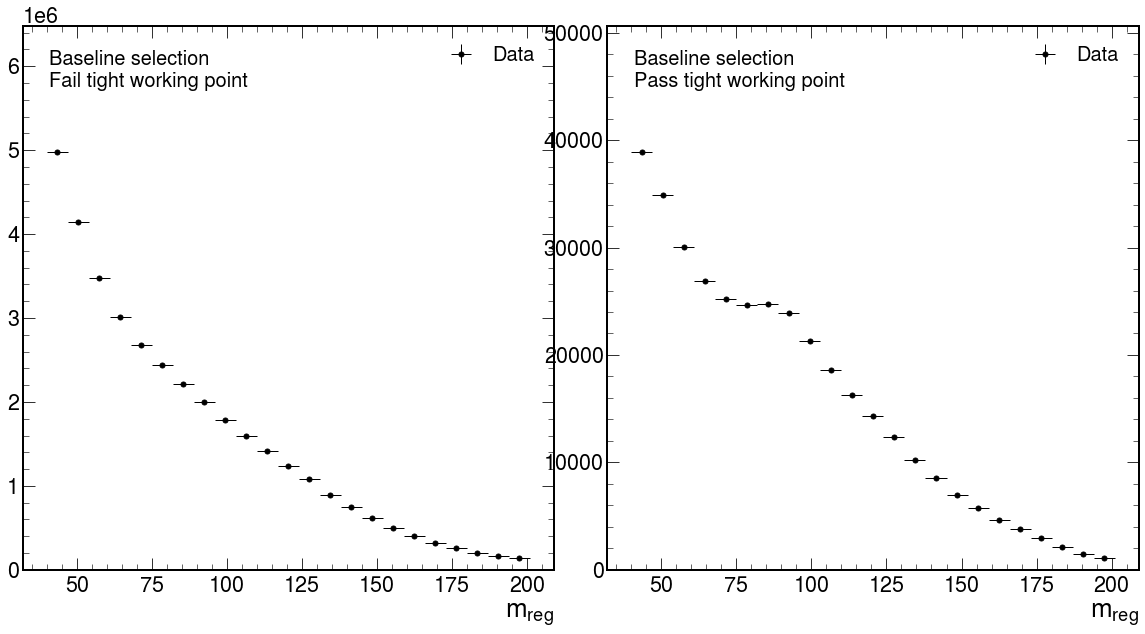

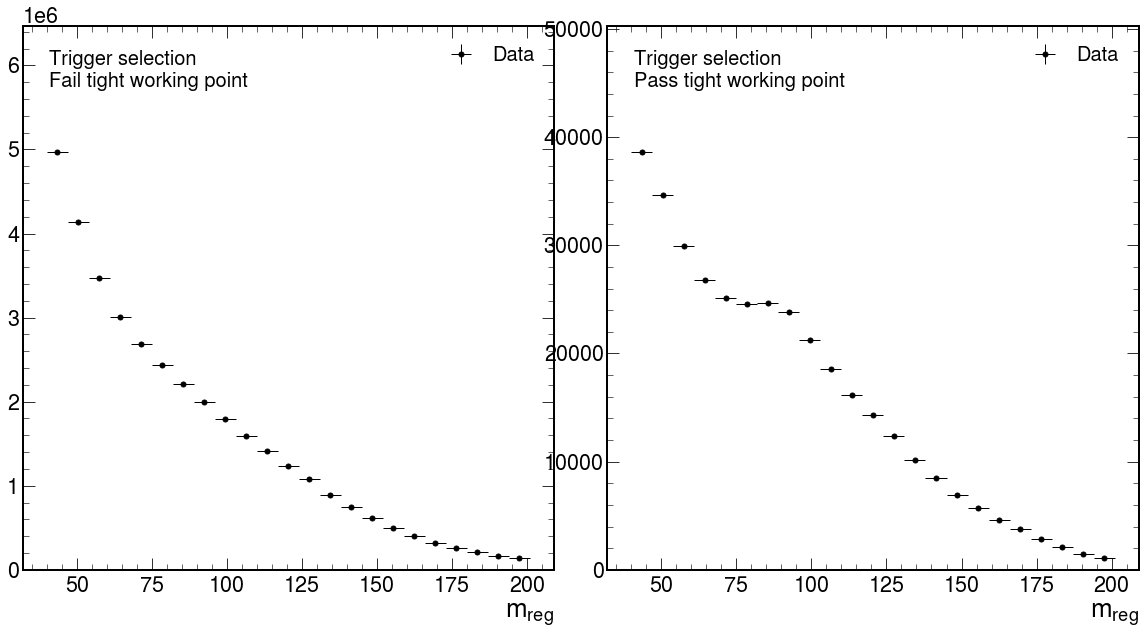

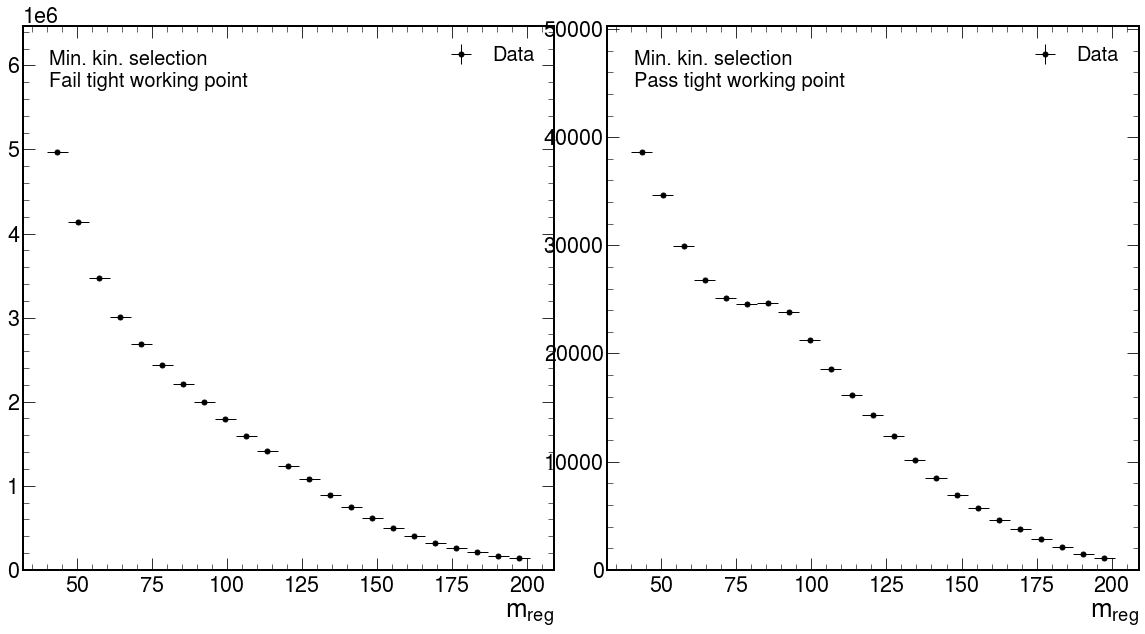

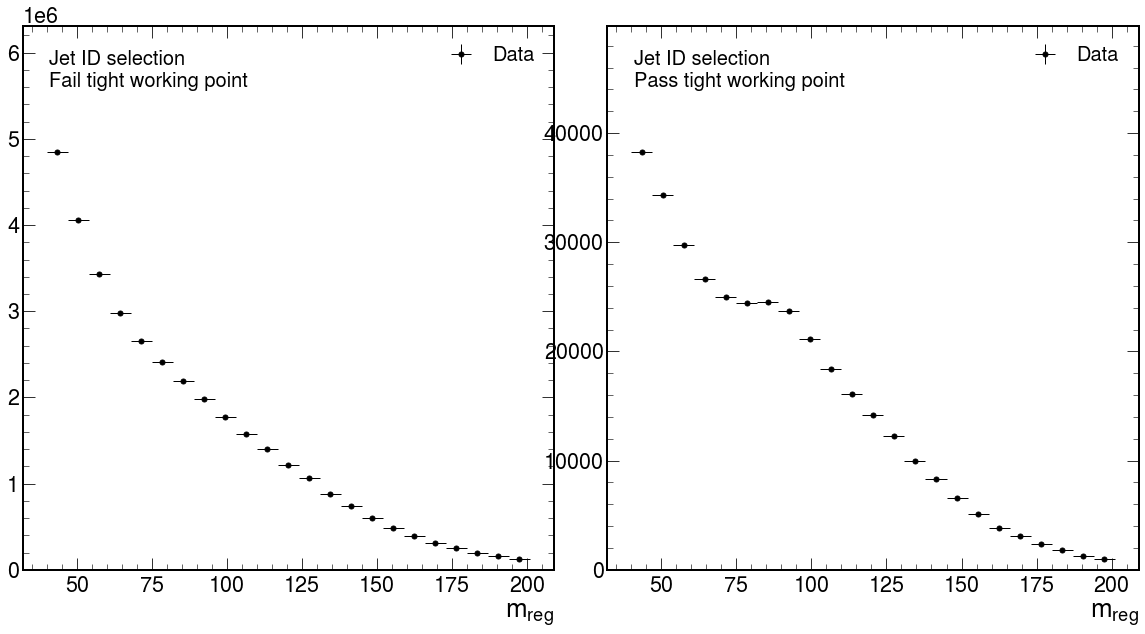

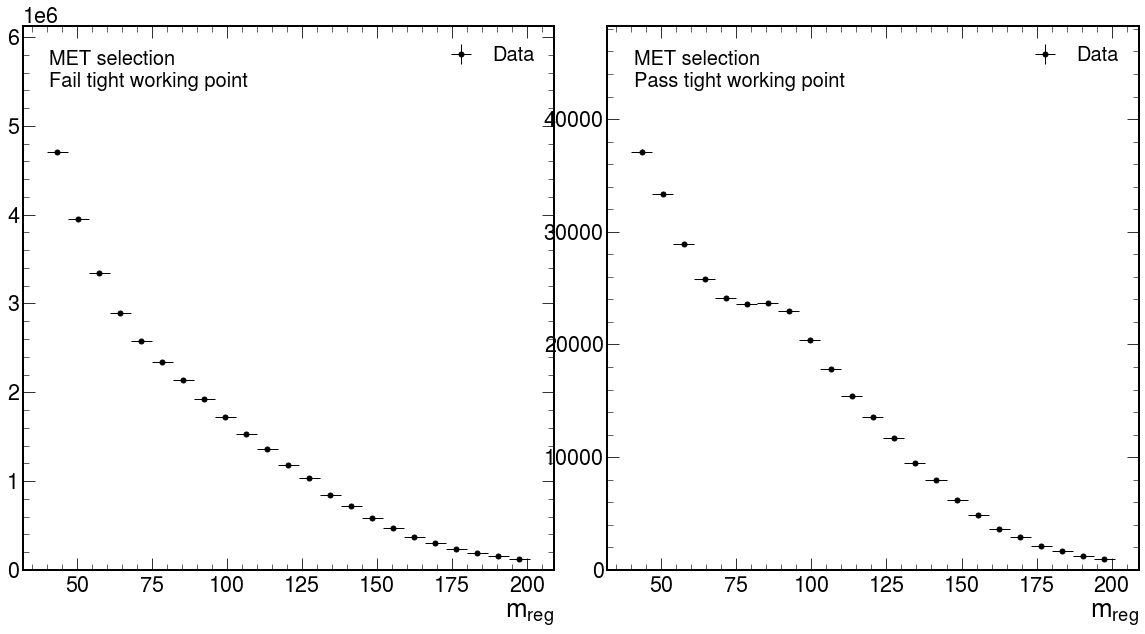

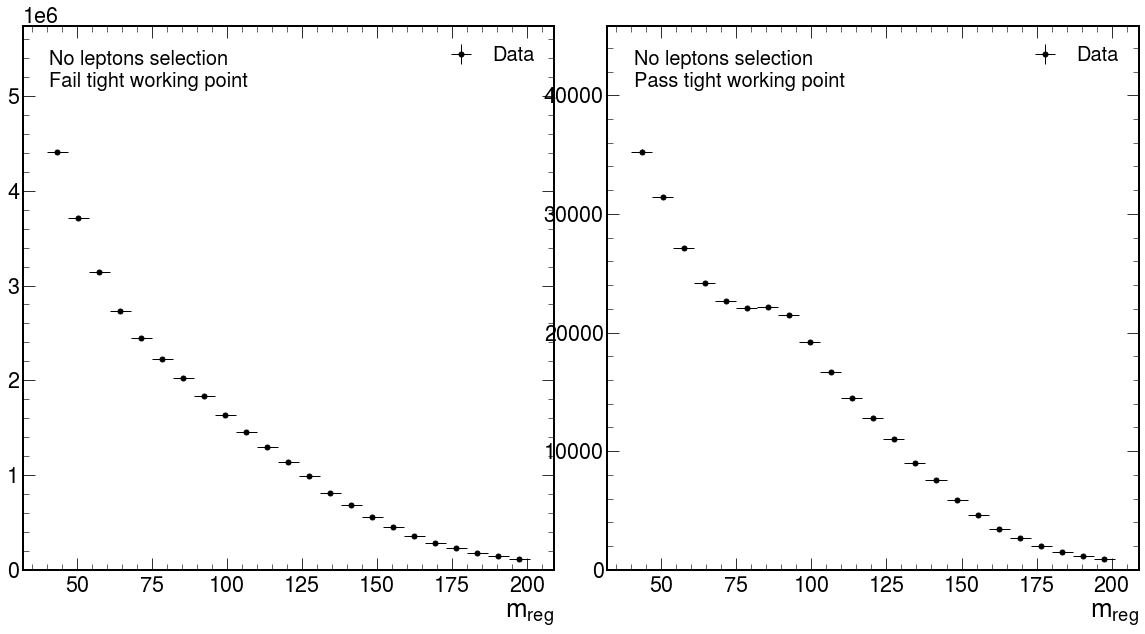

In [25]:
# Data only
# Cutflow plots

plt.style.use(mplhep.style.CMS)

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]
data = pickle.load(open(f'{out_dir}/data.pkl','rb'))

colour = {
    "QCD" : "white",
    "Z(bb)" : "#0033cc",
    "Z(qq)" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "Bkg. H" : "#ffcc00",
}

wps = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3

selections = ['Baseline','Trigger','Min. kin.', 'Jet ID','MET','No leptons']

def get_sel(h, region, process, cut):
    
    alias = {
        "Z(bb)" : hist.loc("ZJets"),
        "Z(qq)" : hist.loc("ZJets"),
        "All mc" : sum,
    }
    
    sel = {
        "pt" : slice(hist.loc(350), len, sum),
        "cut" : cut,
        "process" : alias[process] if process in alias.keys() else hist.loc(process),
    }
    
    h = h[sel]
    
    if process == "Z(bb)":
        h = h[{"genflav" : slice(3, 4, sum)}]
    elif process == "Z(qq)":
        h = h[{"genflav" : slice(1, 3, sum)}]
    else:
        h = h[{"genflav" : slice(0, len, sum)}]
        
    if "Pass" in region:
        h = h[{"disc" : slice(wp, len, sum)}]
    else:
        h = h[{"disc" : slice(0, wp, sum)}]
        
    if process == "data" and region == "Pass":
        for i in [12, 13, 14, 15]:
                h[i] = [np.nan, np.nan]
        
    return h

for i_sel, selection in enumerate(selections):
        
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(20, 10),
    )
    fig.subplots_adjust(wspace=0.1)

    for region, ax in [("Fail", ax1), ("Pass", ax2)]:
    
        ax.set_xlabel(r"$m_{reg}$")

        h_data = get_sel(data, region, "Run3Summer22EE", i_sel)

        mplhep.histplot(
            h_data, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data",
        )

        plt.text(0.05, 0.88, f"{selection} selection\n{region} {wps[wp]} working point",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        ax.legend(loc="upper right", fontsize=20, ncols=2)

        ax.set_ylim(0, max(h_data.values()) * 1.3)

# Create cutflow plots for simulation and data <a class="anchor" id="plot"></a>
[Back to Table of Contents](#toc)

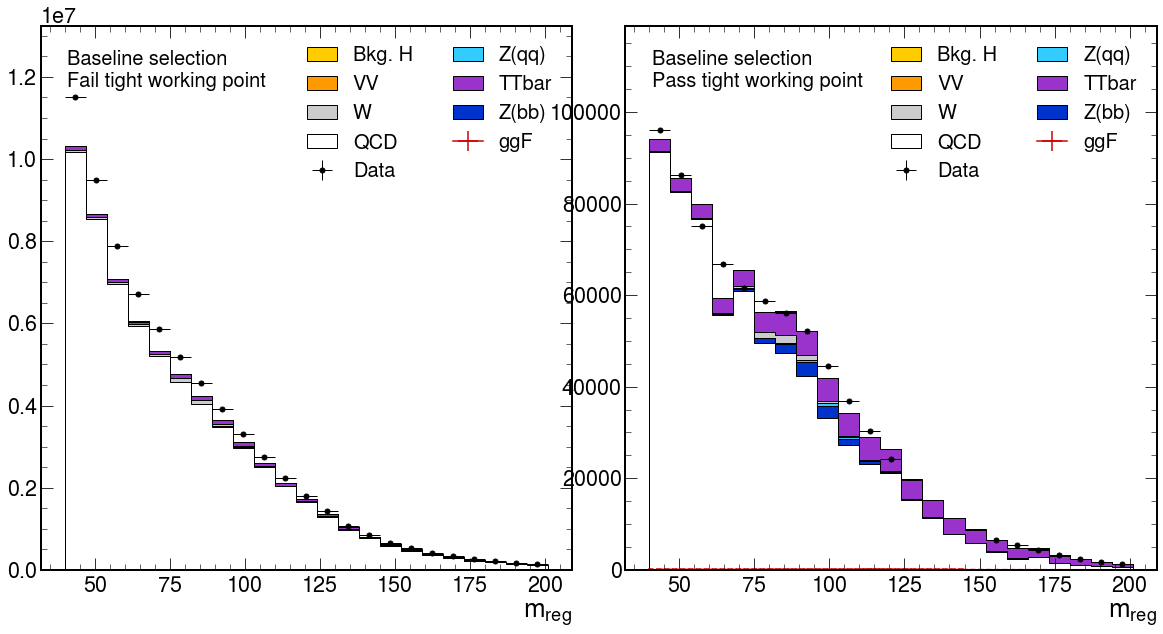

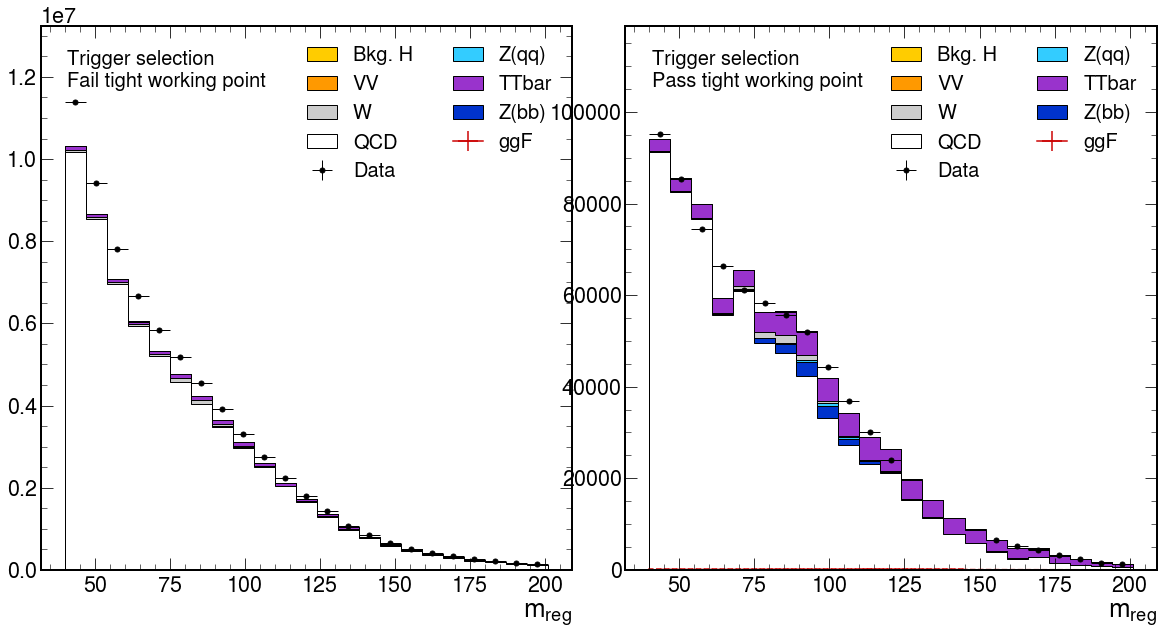

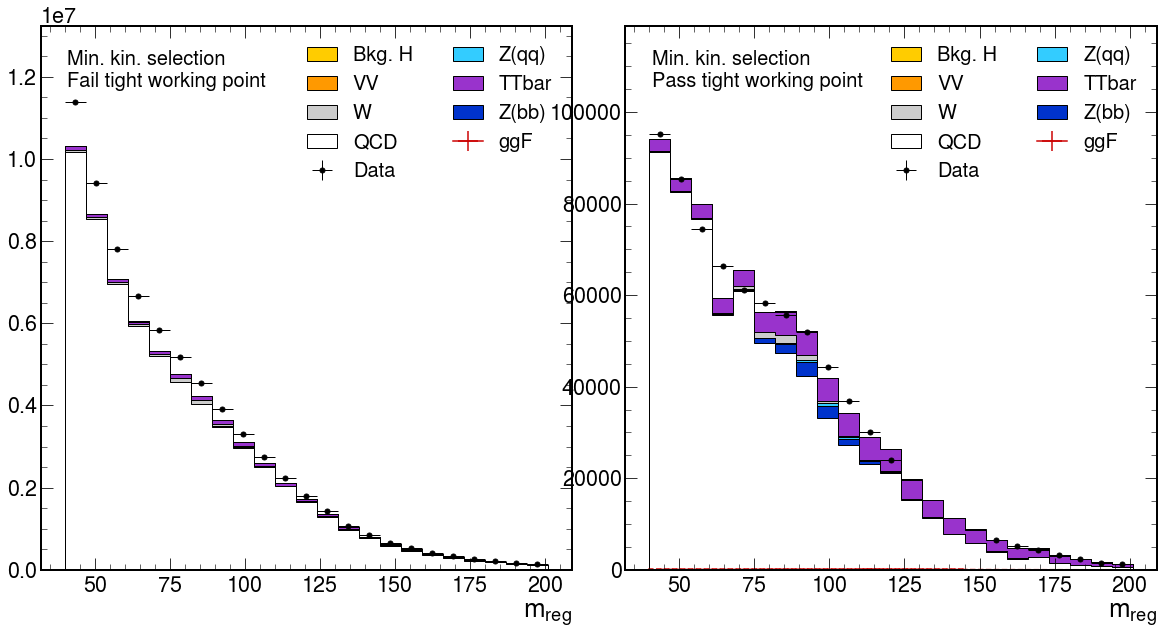

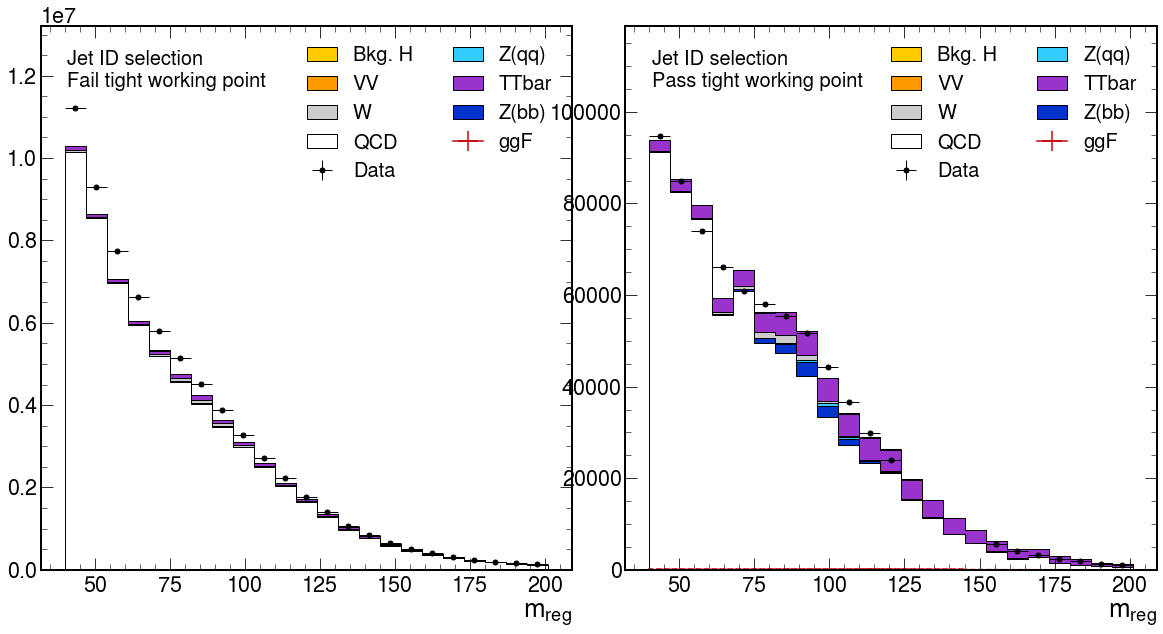

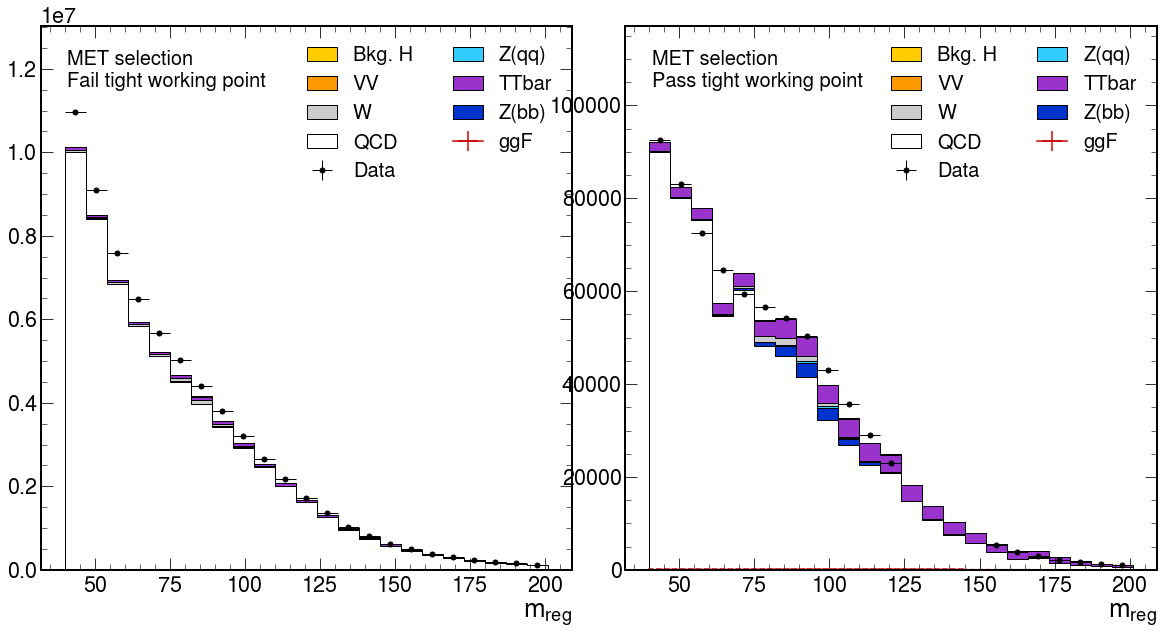

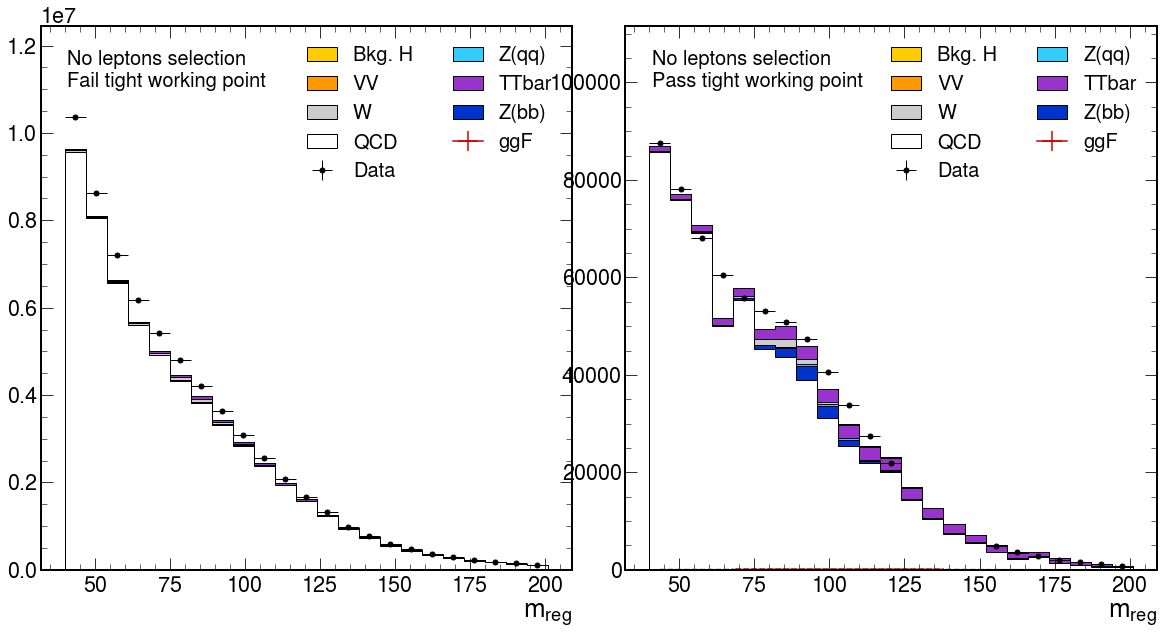

In [30]:
# Data and MC
# Cutflow plots

plt.style.use(mplhep.style.CMS)

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]
data = pickle.load(open(f'{out_dir}/data.pkl','rb'))

colour = {
    "QCD" : "white",
    "Z(bb)" : "#0033cc",
    "Z(qq)" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "Bkg. H" : "#ffcc00",
}

wps = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3
rbin = 1
blind = True

selections = ['Baseline','Trigger','Min. kin.', 'Jet ID','MET','No leptons']

def get_sel(h, region, process, i_sel):
    
    alias = {
        "Z(bb)" : hist.loc("ZJets"),
        "Z(qq)" : hist.loc("ZJets"),
        "All mc" : sum,
    }
    
    sel = {
        "pt" : slice(0, len, sum),
        "cut" : i_sel,
        "process" : alias[process] if process in alias.keys() else hist.loc(process),
    }
    
    h = h[sel]
    
    if process == "Z(bb)":
        h = h[{"genflav" : slice(3, 4, sum)}]
    elif process == "Z(qq)":
        h = h[{"genflav" : slice(1, 3, sum)}]
    else:
        h = h[{"genflav" : slice(0, len, sum)}]
        
    if "Pass" in region:
        h = h[{"disc" : slice(wp, len, sum)}]
    else:
        h = h[{"disc" : slice(0, wp, sum)}]
        
    if process == "Run3Summer22EE" and region == "Pass":
        for i in [12, 13, 14, 15]:
                h[i] = [np.nan, np.nan]
        
    return h

for i_sel, selection in enumerate(selections):

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(20, 10),
    )
    fig.subplots_adjust(wspace=0.1)

    for region, ax in [("Fail", ax1), ("Pass", ax2)]:

        ax.set_xlabel(r"$m_{reg}$")

        hs = []
        labels = []
        colours = []

        for process in colour.keys():

            h = get_sel(mc, region, process, i_sel)

            hs.append(h)
            labels.append(process)
            colours.append(colour[process])

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
        )

        h_ggF = get_sel(mc, "ggF", process, i_sel)

        mplhep.histplot(
            h_ggF, 
            ax=ax, 
            color="#cc0000",
            label=f"ggF",
            linestyle="dashed",
        )

        h_data = get_sel(data, region, "Run3Summer22EE", i_sel)

        mplhep.histplot(
            h_data, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data",
        )

        plt.text(0.05, 0.88, f"{selection} selection\n{region} {wps[wp]} working point",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        handles, labels = ax.get_legend_handles_labels()
        order = [0, 1, 3, 6, 8, 4, 2, 5, 7]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

        ax.set_ylim(0, max(hs[0].values()) * 1.3)

# Create cutflow plots for simulation (separate) <a class="anchor" id="plot-sim-sep"></a>
[Back to Table of Contents](#toc)

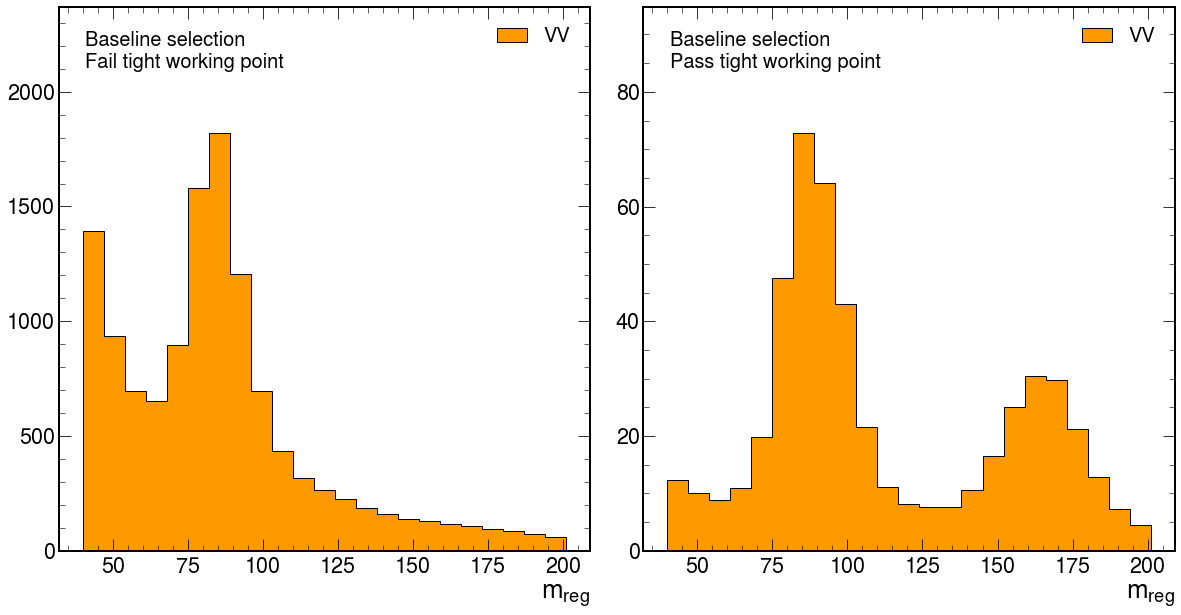

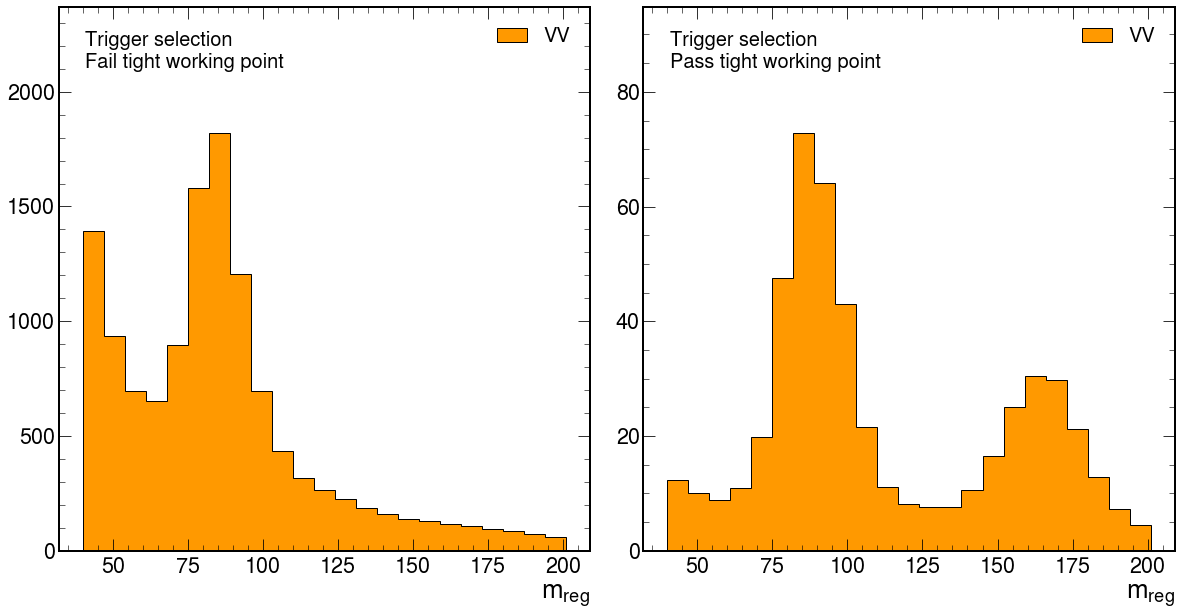

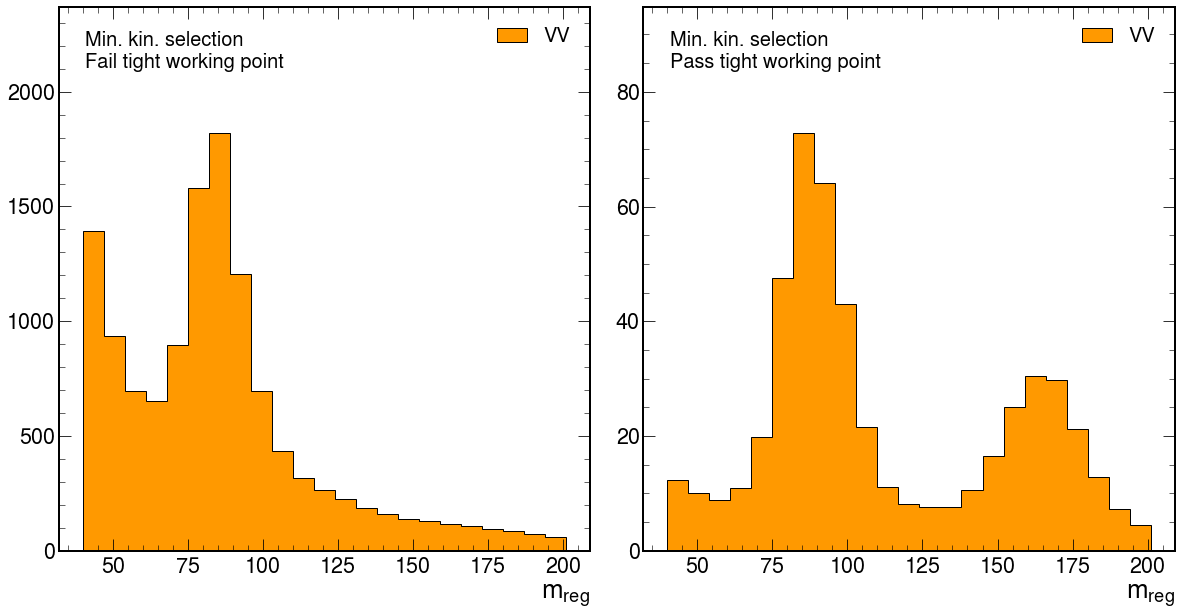

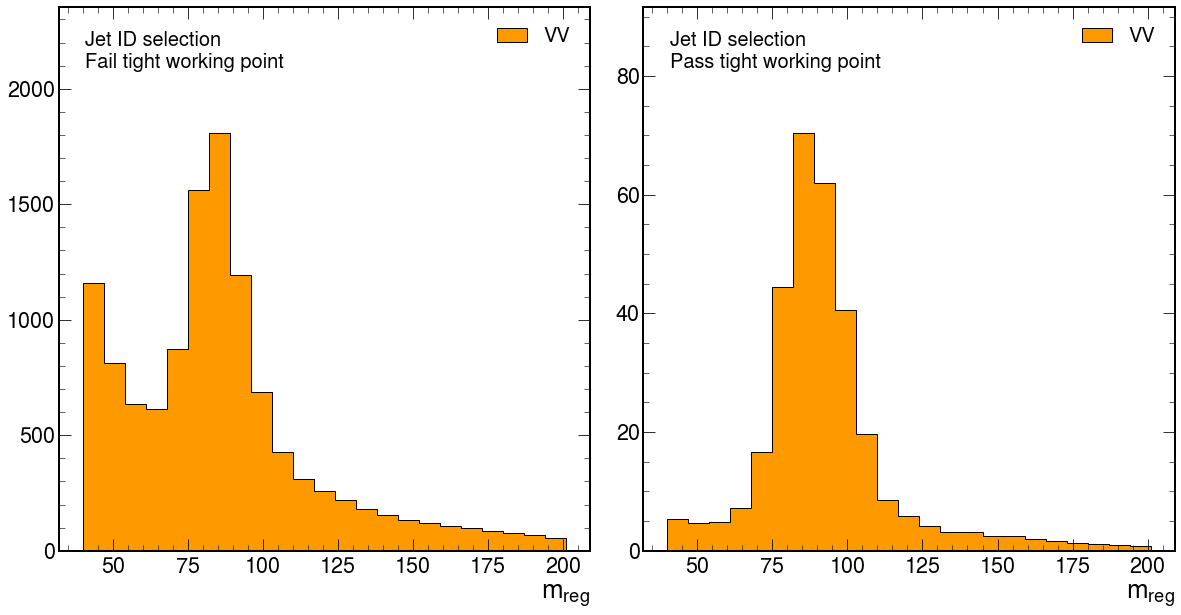

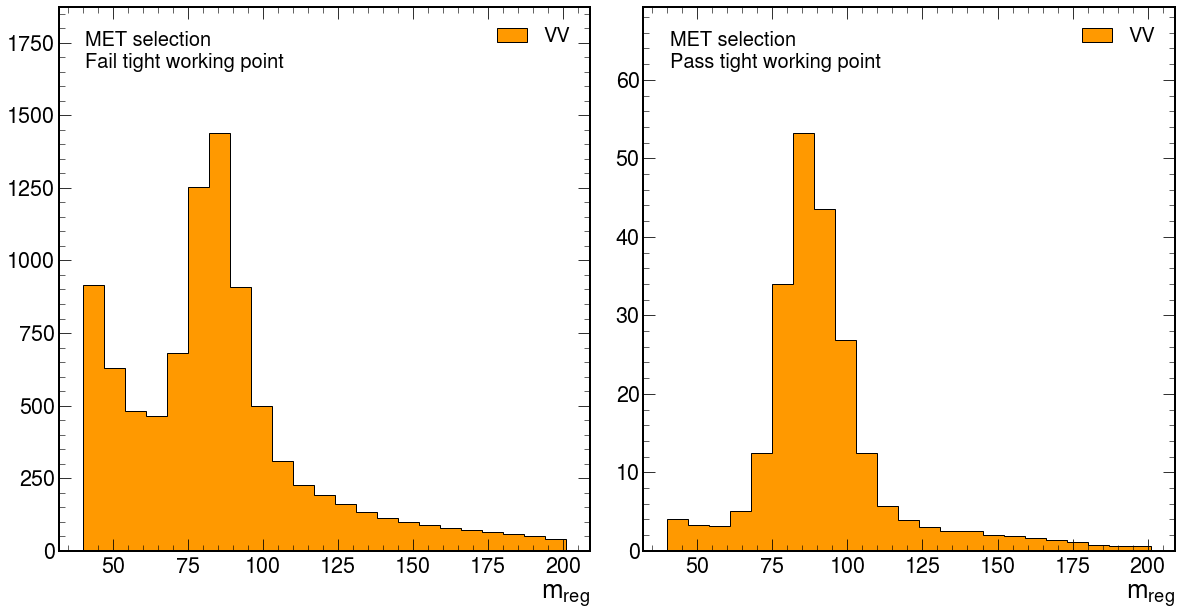

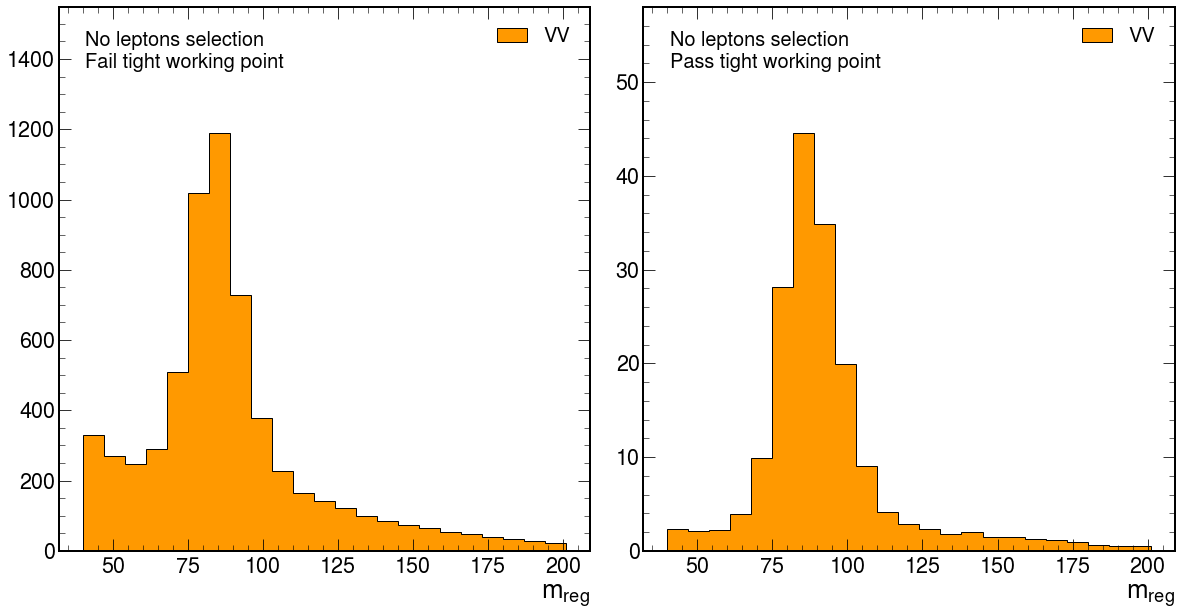

In [33]:
# MC only
# Cutflow plots for only one type of process at a time

plt.style.use(mplhep.style.CMS)

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]

# Uncomment the process you want to plot

colour = {
#     "QCD" : "white",
#     "Z(bb)" : "#0033cc",
#     "Z(qq)" : "#33ccff",
#     "W" : "#cccccc",
#     "TTbar" : "#9933cc",
# #     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
#     "Bkg. H" : "#ffcc00",
#     "VBF" : "#ffcc00",
#     "ZH" : "#ffcc00",
#     "WH" : "#ffcc00",
#     "ttH" : "#ffcc00",
#     "ggF" : "red",
}

wps = {
    1 : "loose",
    2 : "medium",
    3 : "tight",
}

wp = 3

selections = ['Baseline','Trigger','Min. kin.', 'Jet ID','MET','No leptons']

def get_sel(h, region, process, cut):
    
    alias = {
        "Z(bb)" : hist.loc("ZJets"),
        "Z(qq)" : hist.loc("ZJets"),
        "All mc" : sum,
    }
    
    sel = {
        "pt" : slice(hist.loc(350), len, sum),
        "cut" : cut,
        "process" : alias[process] if process in alias.keys() else hist.loc(process),
    }
    
    h = h[sel]
    
    if process == "Z(bb)":
        h = h[{"genflav" : slice(3, 4, sum)}]
    elif process == "Z(qq)":
        h = h[{"genflav" : slice(1, 3, sum)}]
    else:
        h = h[{"genflav" : slice(0, len, sum)}]
        
    if "Pass" in region:
        h = h[{"disc" : slice(wp, len, sum)}]
    else:
        h = h[{"disc" : slice(0, wp, sum)}]
        
    if process == "data" and region == "Pass":
        for i in [12, 13, 14, 15]:
                h[i] = [np.nan, np.nan]
        
    return h

for i_sel, selection in enumerate(selections):
        
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(20, 10),
    )
    fig.subplots_adjust(wspace=0.1)

    for region, ax in [("Fail", ax1), ("Pass", ax2)]:
    
        ax.set_xlabel(r"$m_{reg}$")

        hs = []
        labels = []
        colours = []

        for process in colour.keys():

            h = get_sel(mc, region, process, i_sel)

            hs.append(h)
            labels.append(process)
            colours.append(colour[process])

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
        )

        plt.text(0.05, 0.88, f"{selection} selection\n{region} {wps[wp]} working point",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        ax.legend(loc="upper right", fontsize=20, ncols=2)

        ax.set_ylim(0, max(hs[0].values()) * 1.3)